# Auto Encoder

## 1. Dataset

In [1]:
import os
import numpy as np
np.random.seed(777)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
path_to_cifar10 = 'cifar-10-batches-py/'

In [3]:
if not os.path.isdir(path_to_cifar10):
    ! wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    ! tar -xf cifar-10-python.tar.gz

In [4]:
import cPickle as pickle

def unpickle(file):
    f = open(file, 'rb')
    data = pickle.load(f)
    # pickle.load(f, encoding='latin1') If you can't decode
    f.close()
    return data

In [5]:
train_data = []

for i in range(1,6):
    batch = unpickle(path_to_cifar10+'data_batch_'+str(i))
    train_data.extend(batch['data'])
    
train_data = np.array(train_data).astype(np.float32)
train_data = train_data.reshape(len(train_data),3,32,32) / 255

In [6]:
batch = unpickle(path_to_cifar10 + 'test_batch')
test_data = np.array(batch['data']).astype(np.float32)
test_data = test_data.reshape(len(test_data),3,32,32) / 255

In [7]:
mean = np.mean(train_data, axis=0)
stddev = np.std(train_data, axis=0)
for datum in train_data:
    datum -= mean
    datum /= stddev
for datum in test_data:
    datum -= mean
    datum /= stddev

In [8]:
def imdeprocess(datum):
    im = datum * stddev + mean
    im = im.transpose((1,2,0))
    return im

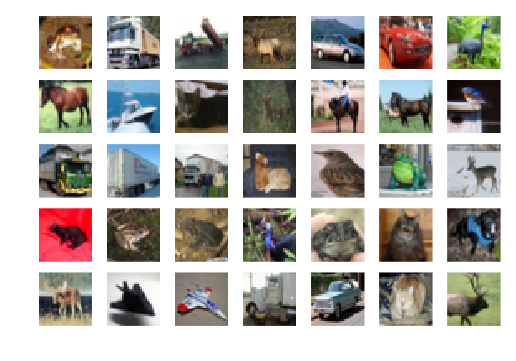

In [9]:
for i in range(0, 35):
    plt.subplot(5, 7, i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]), interpolation='none')

## 2. Model

In [10]:
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

In [11]:
class AE(chainer.Chain):
    
    def __init__(self, n_in, n_h):
        super(AE, self).__init__(
            fc1 = L.Linear(n_in, n_h),
            fc2 = L.Linear(n_h, n_in)
        )
    
    def __call__(self, x, train=True):
        y = self.forward(x, train=train)
        self.loss = F.mean_squared_error(y, x)
        return self.loss

    def forward(self, x, train):
        h = F.dropout(F.relu(self.fc1(x)),train=train)
        h = self.fc2(h)
        return self.h_fc2

In [12]:
size = 6
n_in = 108
n_h = 108
model = AE(n_in, n_h)
optimizer = chainer.optimizers.Adam()
optimizer.use_cleargrads()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))

In [13]:
def crop(images, size=size):
    bs = len(images)
    cropped = np.zeros((bs,3,size,size), dtype=np.float32)
    for k, image in enumerate(images):
        i, j = np.random.randint(0, 32-size, 2)
        cropped[k,:,:,:] = image[:,i:i+size,j:j+size].copy()
    return cropped

In [14]:
gpuid = 0 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpuid >= 0 else np

if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()

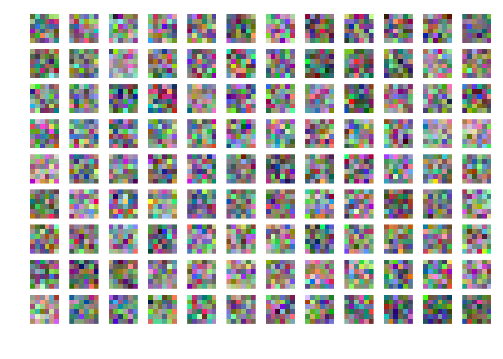

In [15]:
for i in range(0, n_h):
    plt.subplot(9, 12, i+1)
    fmap = model.fc1.W.data[i].reshape(3,size,size)
    if gpuid >= 0:
        fmap = cuda.cupy.asnumpy(fmap)
    fmap -= fmap.min()
    fmap /= fmap.max()
    plt.imshow(fmap.transpose(1,2,0), interpolation='none')
    plt.axis('off')

## 3. Training

In [16]:
import csv

log_train = open('ae_train.log', 'w')
writer_train = csv.writer(log_train, lineterminator='\n')
writer_train.writerow(('iter', 'loss'))

log_test = open('ae_test.log', 'w')
writer_test = csv.writer(log_test, lineterminator='\n')
writer_test.writerow(('iter', 'loss', 'acc'))

In [17]:
batchsize = 100

def test(x):
    sum_loss = 0
    for i in range(0, len(x), batchsize):
        x_batch = crop(x[i:i + batchsize]).reshape(-1,n_in)
        x_batch = chainer.Variable(xp.asarray(x_batch), volatile='on')
        loss = model(x_batch, train=False)
        sum_loss += float(loss.data)
    return sum_loss * batchsize / len(x)

In [18]:
loss = test(test_data)
writer_test.writerow((0, loss))
print('test: loss={0:.6f}'.format(loss))

test: loss=1.369294


In [19]:
from tqdm import tqdm
import sys
n_epoch = 30
n_data = len(train_data)

# Learning loop
for epoch in range(n_epoch):
    sys.stdout.write('(epoch: {})\n'.format(epoch+1))
    sys.stdout.flush()
    
    # training
    perm = np.random.permutation(n_data)
    with tqdm(total=n_data) as pbar:
        for i in range(0, n_data, batchsize):
            it = epoch*n_data + i + batchsize
            x_batch = crop(train_data[perm[i:i + batchsize]]).reshape(-1,n_in)
            x_batch = chainer.Variable(xp.asarray(x_batch), volatile='off')
            optimizer.update(model, x_batch)
            loss = float(model.loss.data)
            writer_train.writerow((it, loss))
            pbar.set_description('train: loss={0:.6f}'.format(loss))
            pbar.update(batchsize)
    sys.stderr.flush()

    # evaluate
    loss = test(test_data)
    writer_test.writerow((it, loss))
    sys.stdout.write('test: loss={0:.6f}\n'.format(loss))

(epoch: 1)


train: loss=0.189597: 100%|██████████| 50000/50000 [00:03<00:00, 14382.48it/s]


test: loss=0.084445
(epoch: 2)


train: loss=0.148166: 100%|██████████| 50000/50000 [00:03<00:00, 13259.62it/s]


test: loss=0.073774
(epoch: 3)


train: loss=0.176126: 100%|██████████| 50000/50000 [00:03<00:00, 14484.09it/s]


test: loss=0.076143
(epoch: 4)


train: loss=0.176861: 100%|██████████| 50000/50000 [00:03<00:00, 14213.03it/s]


test: loss=0.075439
(epoch: 5)


train: loss=0.149296: 100%|██████████| 50000/50000 [00:03<00:00, 14640.39it/s]


test: loss=0.072179
(epoch: 6)


train: loss=0.162332: 100%|██████████| 50000/50000 [00:04<00:00, 11239.74it/s]


test: loss=0.070249
(epoch: 7)


train: loss=0.136503: 100%|██████████| 50000/50000 [00:03<00:00, 14617.35it/s]


test: loss=0.069994
(epoch: 8)


train: loss=0.172646: 100%|██████████| 50000/50000 [00:03<00:00, 14182.99it/s]


test: loss=0.071040
(epoch: 9)


train: loss=0.129537: 100%|██████████| 50000/50000 [00:03<00:00, 15247.58it/s]


test: loss=0.072184
(epoch: 10)


train: loss=0.168904: 100%|██████████| 50000/50000 [00:03<00:00, 13751.13it/s]


test: loss=0.075728
(epoch: 11)


train: loss=0.173319: 100%|██████████| 50000/50000 [00:03<00:00, 15279.53it/s]


test: loss=0.069914
(epoch: 12)


train: loss=0.160244: 100%|██████████| 50000/50000 [00:04<00:00, 11835.56it/s]


test: loss=0.069891
(epoch: 13)


train: loss=0.145320: 100%|██████████| 50000/50000 [00:03<00:00, 14041.90it/s]


test: loss=0.073608
(epoch: 14)


train: loss=0.167793: 100%|██████████| 50000/50000 [00:03<00:00, 16150.27it/s]


test: loss=0.077467
(epoch: 15)


train: loss=0.142302: 100%|██████████| 50000/50000 [00:03<00:00, 13949.53it/s]


test: loss=0.068941
(epoch: 16)


train: loss=0.161735: 100%|██████████| 50000/50000 [00:03<00:00, 15773.83it/s]


test: loss=0.073646
(epoch: 17)


train: loss=0.131020: 100%|██████████| 50000/50000 [00:03<00:00, 15002.84it/s]


test: loss=0.069938
(epoch: 18)


train: loss=0.138816: 100%|██████████| 50000/50000 [00:03<00:00, 16226.92it/s]


test: loss=0.072150
(epoch: 19)


train: loss=0.152252: 100%|██████████| 50000/50000 [00:03<00:00, 12647.03it/s]


test: loss=0.072018
(epoch: 20)


train: loss=0.165201: 100%|██████████| 50000/50000 [00:03<00:00, 14935.56it/s]


test: loss=0.069090
(epoch: 21)


train: loss=0.135493: 100%|██████████| 50000/50000 [00:03<00:00, 14090.98it/s]


test: loss=0.071950
(epoch: 22)


train: loss=0.156510: 100%|██████████| 50000/50000 [00:02<00:00, 16841.11it/s]


test: loss=0.068613
(epoch: 23)


train: loss=0.149478: 100%|██████████| 50000/50000 [00:03<00:00, 14321.64it/s]


test: loss=0.068560
(epoch: 24)


train: loss=0.161558: 100%|██████████| 50000/50000 [00:03<00:00, 14476.69it/s]


test: loss=0.067677
(epoch: 25)


train: loss=0.149163: 100%|██████████| 50000/50000 [00:03<00:00, 16112.55it/s]


test: loss=0.067088
(epoch: 26)


train: loss=0.148095: 100%|██████████| 50000/50000 [00:03<00:00, 15344.16it/s]


test: loss=0.068784
(epoch: 27)


train: loss=0.158715: 100%|██████████| 50000/50000 [00:03<00:00, 16240.11it/s]


test: loss=0.068645
(epoch: 28)


train: loss=0.159704: 100%|██████████| 50000/50000 [00:03<00:00, 16652.81it/s]


test: loss=0.067554
(epoch: 29)


train: loss=0.145933: 100%|██████████| 50000/50000 [00:03<00:00, 15927.28it/s]


test: loss=0.068131
(epoch: 30)


train: loss=0.151414: 100%|██████████| 50000/50000 [00:03<00:00, 14742.50it/s]


test: loss=0.069670


In [20]:
log_train.close()
log_test.close()
log_train = np.loadtxt('ae_train.log', delimiter=',', skiprows=True).transpose()
log_test = np.loadtxt('ae_test.log', delimiter=',', skiprows=True).transpose()

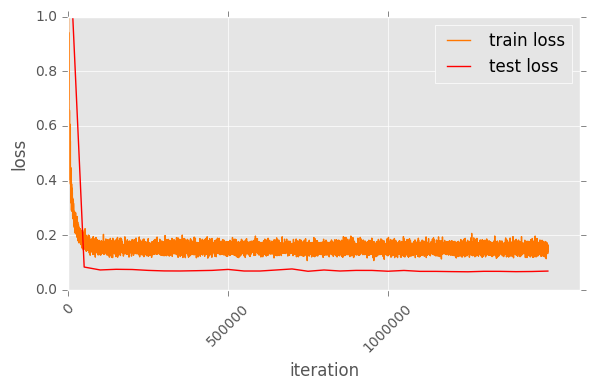

In [21]:
plt.plot(log_train[0], log_train[1], ls='-', color='#ff7700')
plt.plot(log_test[0], log_test[1], 'r-')
plt.xlabel('iteration')
plt.xticks(range(0, int(log_train[0,-1]), 500000), rotation=45)
plt.ylabel('loss')
plt.ylim(0, 1)
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1,1), framealpha=1)
plt.tight_layout()
plt.show()

## 4. Visualize trained weights

In [22]:
x = crop(test_data[1:2])
x -= x.min()
x /= x.max()

In [23]:
inputs = chainer.Variable(xp.asarray(x.reshape(-1,n_in)), volatile='off')
outputs = model.forward(inputs, train=False)
x_hat = outputs.data.reshape(-1,3,size,size)
if gpuid >= 0:
    x_hat = cuda.cupy.asnumpy(x_hat)
x_hat -= x_hat.min()
x_hat /= x_hat.max()

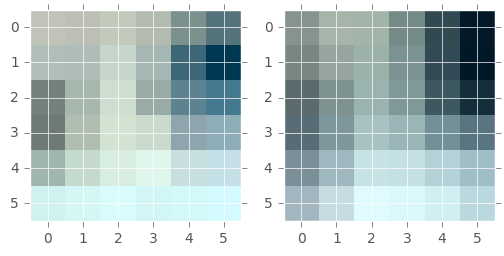

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(x[0].transpose((1,2,0)), interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(x_hat[0].transpose((1,2,0)), interpolation='none')

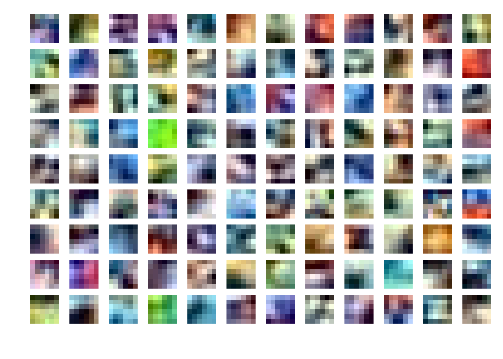

In [25]:
for i in range(0, n_h):
    plt.subplot(9, 12, i+1)
    fmap = model.fc1.W.data[i].reshape(3,size,size)
    if gpuid >= 0:
        fmap = cuda.cupy.asnumpy(fmap)
    fmap -= fmap.min()
    fmap /= fmap.max()
    plt.imshow(fmap.transpose(1,2,0), interpolation='none')
    plt.axis('off')